# EDA of Teranet data with added columns
This notebook presents Exploratory Data Analysis (EDA) for Teranet records that were:
* cleaned and filtered for duplicates
    * `consideration_amt` < $30 reset to NaN (Not a Number, missing values)
    * records matching on all columns have been removed (83'798 records)
    * records matching on all columns excluding `pin` have been removed (729'182 records)
    * **813'138 duplicate entries** removed in total from original Teranet dataset 
    * 8'226'103 unique records remain after duplicates have been removed
    * see notebook `data_cleaning/Teranet_data_cleaning.ipynb` for details
* filtered to include only records from GTHA 
    * filtering performed via a spatial join
    * `xy` coordinates of Teranet records joined (how='inner', op='within') with DA geometry for GTHA 
    * DA geometry provided by York Municipal Government (accessed via Esri Open Data portal)
    * 6,062,853 records have `xy` coordinates within GTHA boundary
    * see notebook `data_cleaning/Teranet_GTHA_DA_spatial_join.ipynb` for details
* filtered to exclude records with missing (or under $30) `consideration_amt`
    * `consideration_amt` < $30 was reset to NaN during data cleaning
    * records with `consideration_amt` == NaN were removed before adding new columns
    * 4,637,584 records have non-NaN `consideration_amt`
    * see notebook `feature_extraction/Teranet_feature_extraction.ipynb` for details
* new columns added (available on transaction level):
    * `da_id`, `da_city`, `da_median_tot_inc`: were added during the spatial join with DA data
    * `xy`: `x` and `y` concatenated together (used for grouping by coordinate pairs)
    * `pin/xy_total_sales`: total records for this `pin`/`xy`
    * `pin/xy_prev_sales`: previous records from this `pin`/`xy` (not counting current transaction)
    * `pin/xy_price_cum_sum`: cumulative price of all records to date from this `pin`/`xy`
    * `pin/xy_price_pct_change`: price percentage change compared to previous record from this `pin`/`xy`
    * `price_da_pct_change`: price percentage change compared to previous record from this DA (by `da_id`)
    * `pin/xy_years_since_last_sale`: years since last sale from this `pin`/`xy`
    * `da_days_since_last_sale`, `da_years_since_last_sale`: days or years since last sale from this DA (by `da_id`)
    * `pin/xy_sale_next_1y/3y`, whether this `pin` or `xy` will have another sale in the future
    * `sale_next_6m/1y/3y`: "looks into the future" to see whether there is another transaction from this `pin`/`xy` within the given time horizon (6 months, 1 year, 3 years)
    * see notebook `Teranet_feature_extraction.ipynb` for details
    * data types are described below

## Preparations
### Import dependencies

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import time
import os

In [2]:
os.chdir('Documents/repos/geo')
os.listdir()

['.git',
 '.gitattributes',
 '.gitignore',
 '.idea',
 '.ipynb_checkpoints',
 'data',
 'img',
 'notebooks',
 'presentations',
 'README.md',
 'src',
 '__pycache__']

## Load Teranet records with added columns

In [3]:
# column `pin` will be converted to dtype=category
# after records with NaN `consideration_amt` will be dropped
dtypes = {
    'decade': 'int',
    'year': 'int',
    'lro_num': 'category',
    'pin': 'category',
    'postal_code': 'category',
    'street_designation': 'category',
    'street_direction': 'category',
    'municipality': 'category',
    'da_id': 'category',
    'da_city': 'category',
}
t = time.time()
teranet_path = 'data/HHSaleHistory_cleaned_v0.9_GTHA_DA_with_cols_v0.9.csv'
df = pd.read_csv(teranet_path,
                 dtype=dtypes,
                 parse_dates=['registration_date'])
df = df.sort_values('registration_date')
elapsed = time.time() - t
print("----- DataFrame with Teranet records loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- DataFrame with Teranet records loaded
in 139.04 seconds
with 4,637,584 rows
and 38 columns
-- Column names:
 Index(['registration_date', 'decade', 'year', 'lro_num', 'pin',
       'consideration_amt', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'da_id', 'da_city', 'da_median_tot_inc',
       'xy', 'pin_total_sales', 'xy_total_sales', 'pin_prev_sales',
       'xy_prev_sales', 'pin_price_cum_sum', 'xy_price_cum_sum',
       'pin_price_pct_change', 'xy_price_pct_change', 'price_da_pct_change',
       'pin_years_since_last_sale', 'xy_years_since_last_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'pin_sale_next_6m', 'pin_sale_next_1y', 'pin_sale_next_3y',
       'xy_sale_next_6m', 'xy_sale_next_1y', 'xy_sale_next_3y'],
      dtype='object')


In [4]:
df.head()

,registration_date,decade,year,lro_num,pin,consideration_amt,postal_code,unitno,street_name,street_designation,...,pin_years_since_last_sale,xy_years_since_last_sale,da_days_since_last_sale,da_years_since_last_sale,pin_sale_next_6m,pin_sale_next_1y,pin_sale_next_3y,xy_sale_next_6m,xy_sale_next_1y,xy_sale_next_3y
1545768,1824-03-06,182,1824,80,214120243,1550.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
1245151,1824-03-09,182,1824,80,210940168,950.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
3302475,1827-09-13,182,1827,65,33960127,800.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
4391283,1828-12-16,182,1828,62,171670055,100.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
4400085,1829-01-13,182,1829,62,171670030,250.0,NaN,NaN,NaN,NaN,...,NaN,NaN,28.0,0.076712,False,False,False,False,False,False


In [5]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4637584 entries, 1545768 to 1687675
Data columns (total 38 columns):
registration_date            4637584 non-null datetime64[ns]
decade                       4637584 non-null int32
year                         4637584 non-null int32
lro_num                      4637584 non-null category
pin                          4637584 non-null category
consideration_amt            4637584 non-null float64
postal_code                  4342478 non-null category
unitno                       1140626 non-null float64
street_name                  4588439 non-null object
street_designation           4327098 non-null category
street_direction             424608 non-null category
municipality                 4635981 non-null category
street_number                4587129 non-null float64
x                            4637584 non-null float64
y                            4637584 non-null float64
da_id                        4637584 non-null category
da_city  

## Create a GeoDataFrame from Teranet records
`x` and `y` coordinates are combined to form Point objects, CRS information for WGS84 is added.

In [6]:
t = time.time()
# combine values in columns 'x' and 'y' into a Point geometry object
geometry = [Point(xy) for xy in zip(df['x'], df['y'])]

# generate a new GeoDataFrame by adding point geometry to data frame 'teranet_sales_data'
gdf = gpd.GeoDataFrame(df, geometry=geometry)
elapsed = time.time() - t
print("Geometry generated from 'x' and 'y' pairs, GeoDataFrame created!"
      "\ntook {0:.2f} seconds.".format(elapsed))
# add CRS for WGS84 (lat-long) to GeoDataFrame 'sales_data_geo'
gdf.crs = {'proj': 'latlong', 
           'ellps': 'WGS84', 
           'datum': 'WGS84', 
           'no_defs': True}
print("CRS dictionary for WGS84 added to geoDataFrame with Teranet records!")

Geometry generated from 'x' and 'y' pairs, GeoDataFrame created!
took 48.64 seconds.
CRS dictionary for WGS84 added to geoDataFrame with Teranet records!


## Load DA geometry for GTHA
Provided by York Municipal Government, accessed via Esri Open Data portal.

GeoDataFrame 'da_income_gdf' with profile of income by dissimination areas created!


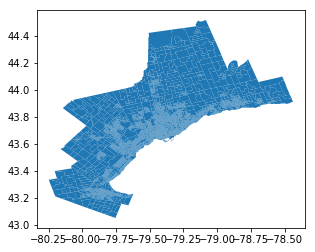

In [7]:
api_url = 'https://opendata.arcgis.com/datasets/9d262f8a576842fbb2afbc8c51a64178_1.geojson'
da_income_gdf = gpd.read_file(api_url)
print("GeoDataFrame 'da_income_gdf' with profile of income by dissimination areas created!")
da_income_gdf.plot();

## Records per `pin` vs records per `xy` pair
There are significantly more records with unique `pin` compared to unique `xy` coordinate pairs, which appears to be reasonable (some `xy` coordinate pairs correspond to records with different`pin`s).

In [8]:
df['pin'].describe()

count       4637584
unique      2219927
top       211080033
freq            464
Name: pin, dtype: object

In [9]:
df['xy'].describe()

count                                 4637584
unique                                1394189
top       -79.413759934962343.776162782863395
freq                                     7222
Name: xy, dtype: object

In [10]:
# get counts of Teranet records per `pin` and `xy`
pin_counts = df.groupby('pin')['pin_total_sales'].max()
xy_counts = df.groupby('xy')['xy_total_sales'].max()
# print top 10 pins and xy by count of Teranet records
print("Top 10 pins by count of Teranet records\n")
print(pin_counts.sort_values(ascending=False).head(10))
print("\n\nTop 10 xy pairs by count of Teranet records\n")
print(xy_counts.sort_values(ascending=False).head(10))

Top 10 pins by count of Teranet records

pin
211080033    464
102510001    427
102510739    298
212620005    230
100350680    178
211670083    164
34970524     164
213730048    150
213730131    147
249120194    137
Name: pin_total_sales, dtype: int64


Top 10 xy pairs by count of Teranet records

xy
-79.413759934962343.776162782863395    7222
-79.2456944938007143.7818021274138     7191
-79.250518675988443.7808645632733      7011
-79.405482240397443.6368161615753      6998
-79.384129984420743.6602602350572      6868
-79.635284627778643.5952539512044      6866
-79.3915756753400143.6399407723945     6671
-79.413500628895843.765742894885705    6251
-79.536251390347243.63888916852368     6143
-79.376537425875743.64301674059521     5873
Name: xy_total_sales, dtype: int64


In [ ]:
min_records = 10
f, axes = plt.subplots(nrows=1, ncols=2)
plt.suptitle("Histogram of Teranet records per `pin` or `xy`")
# plot histogram of records per pin
pin_counts[pin_counts <= min_records].plot(kind='bar', ax=axes[0])
axes[0].text(1, 700000, "Mean: {0:,.2f}"
             .format(pin_counts[pin_counts <= min_records].mean()), 
             ha='left')
axes[0].text(2, 600000, "Median: {0:,.2f}"
             .format(pin_counts[pin_counts <= min_records].median()), 
             ha='left')
axes[0].get_yaxis()\
    .set_major_formatter(plt.FuncFormatter(lambda x, 
                                    loc: "{:,}".format(int(x))))
axes[0].set_title("for pins with <=10 records")
axes[0].set_ylabel("# of pins")
axes[0].set_xlabel("# of Teranet records")
axes[0].grid(linestyle=':')

# plot histogram of records per pin
xy_counts[xy_counts <= min_records].plot(kind='bar', ax=axes[0])
axes[1].text(1, 450000, "Mean: {0:,.2f}"
             .format(xy_counts[xy_counts <= min_records].mean()), ha='left')
axes[1].text(2, 350000, "Median: {0:,.2f}"
             .format(xy_counts[xy_counts <= min_records].median()), ha='left')
axes[1].get_yaxis()\
    .set_major_formatter(plt.FuncFormatter(lambda x, 
                                    loc: "{:,}".format(int(x))))
axes[1].set_title("\nfor xy pairs with <=10 records")
axes[1].set_ylabel("# of xy coordinate pairs")
axes[1].set_xlabel("# of Teranet records")
axes[1].grid(linestyle=':')

plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



## Mapping `pin` and `xy` with larger number of records
### Map pins with a larger number of records

In [11]:
# set index of GeoDataFrame with Teranet records to `pin`
gdf = gdf.set_index('pin')
print("GeoDataFrame index set to `pin`!")

GeoDataFrame index set to `pin`!


#### > 10 Teranet records per `pin`
Only 465 pins (0.02% of the total) have more than 10 Teranet records.

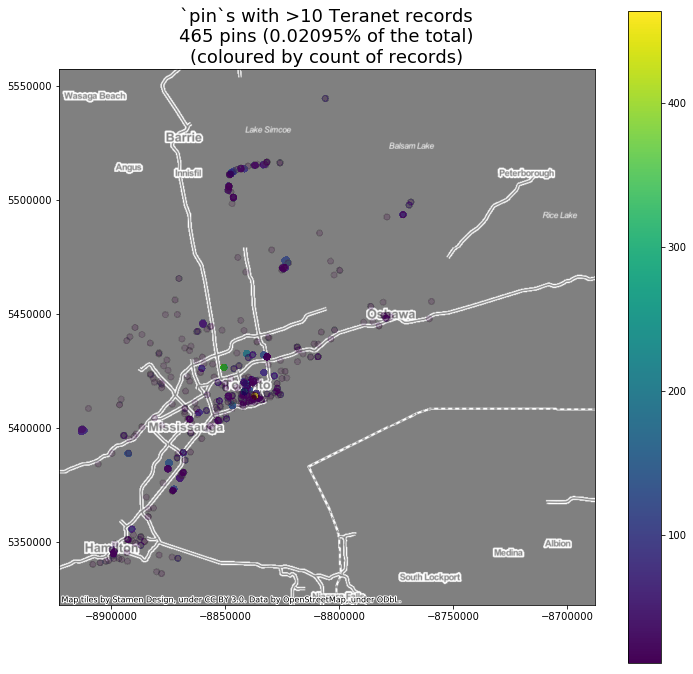

In [12]:
min_records = 10 # min Teranet records, to filter pins
# select subset of pins that have >min_records records
focus_ids = pin_counts[pin_counts > min_records].index
# plot results
f, ax = plt.subplots(1, figsize=(12, 12))
gdf.loc[focus_ids].to_crs(epsg=3857)\
    .plot(column='pin_total_sales', legend=True, ax=ax, alpha=0.01)
# noinspection PyTypeChecker
ctx.add_basemap(ax=ax, url=ctx.sources.ST_TONER_HYBRID, alpha=0.5)
plt.title("`pin`s with >{0} Teranet records"
          .format(min_records) + 
          "\n{0:,} pins ({1:.5f}% of the total)"
          .format(gdf.loc[focus_ids].index.nunique(),
                  gdf.loc[focus_ids].index.nunique()
                        / len(pin_counts) * 100) + 
          "\n(coloured by count of records)",
          fontsize=18)
plt.show()

#### > 100 Teranet records per `pin`
Only 30 pins (0.001% of the total) have more than 100 Teranet records.

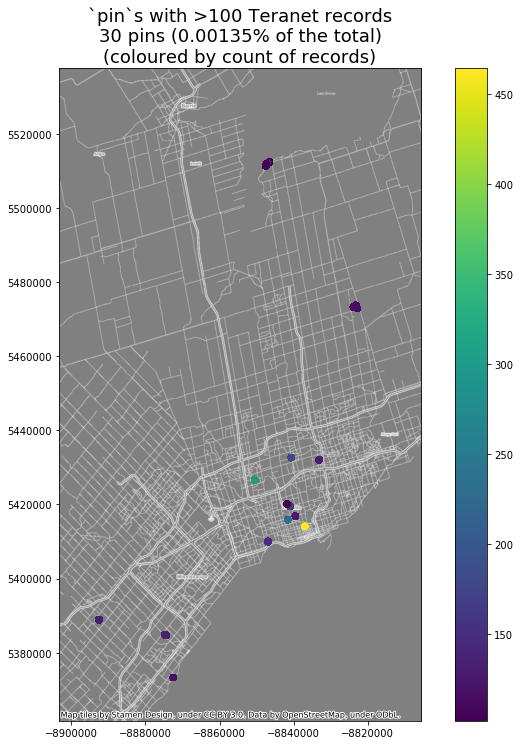

In [13]:
min_records = 100 # min Teranet records, to filter pins
# get counts of Teranet records per `pin`
pin_counts = df.groupby('pin')['pin_total_sales'].max()
# select subset of pins that have >min_records records
focus_ids = pin_counts[pin_counts > min_records].index
# plot results
f, ax = plt.subplots(1, figsize=(12, 12))
gdf.loc[focus_ids].to_crs(epsg=3857)\
    .plot(column='pin_total_sales', legend=True, ax=ax)
# noinspection PyTypeChecker
ctx.add_basemap(ax=ax, url=ctx.sources.ST_TONER_HYBRID, alpha=0.5)
plt.title("`pin`s with >{0} Teranet records"
          .format(min_records) + 
          "\n{0:,} pins ({1:.5f}% of the total)"
          .format(gdf.loc[focus_ids].index.nunique(),
                  gdf.loc[focus_ids].index.nunique()
                        / len(pin_counts) * 100) +
          "\n(coloured by count of records)",
          fontsize=18)
plt.show()

### Map `xy`s with a larger number of records

In [14]:
# set index of GeoDataFrame with Teranet records to `pin`
gdf = gdf.reset_index()
gdf = gdf.set_index('xy')

#### > 10 Teranet records per `xy` pair
Only 5,350 `xy` pairs (0.38% of the total) have more than 10 Teranet records.  
However, this number is over 10 times the number of pins with >10 records.

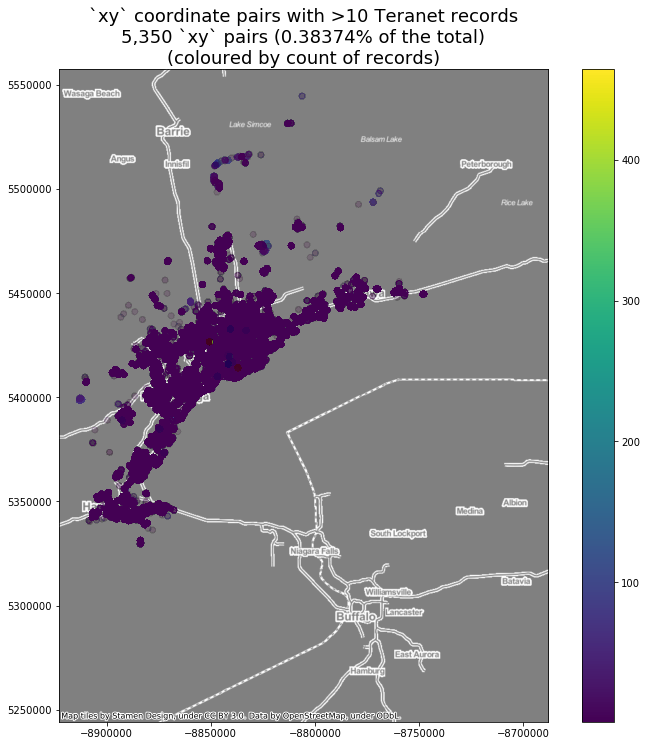

In [15]:
min_records = 10 # min Teranet records, to filter xy pairs
# select subset of `xy` that have >min_records records
focus_ids = xy_counts[xy_counts > min_records].index
# plot results
f, ax = plt.subplots(1, figsize=(12, 12))
gdf.loc[focus_ids].to_crs(epsg=3857)\
    .plot(column='pin_total_sales', legend=True, ax=ax, alpha=0.01)
# noinspection PyTypeChecker
ctx.add_basemap(ax=ax, url=ctx.sources.ST_TONER_HYBRID, alpha=0.5)
plt.title("`xy` coordinate pairs with >{0} Teranet records"
          .format(min_records) + 
          "\n{0:,} `xy` pairs ({1:.5f}% of the total)"
          .format(gdf.loc[focus_ids].index.nunique(),
                  gdf.loc[focus_ids].index.nunique()
                        / len(xy_counts) * 100) +
          "\n(coloured by count of records)",
          fontsize=18)
plt.show()

#### > 100 Teranet records per `xy` pair
Only 2,985 `xy` pairs (0.21% of the total) have more than 100 Teranet records.  
However, this number is almost 100 times the number of pins with >100 records.

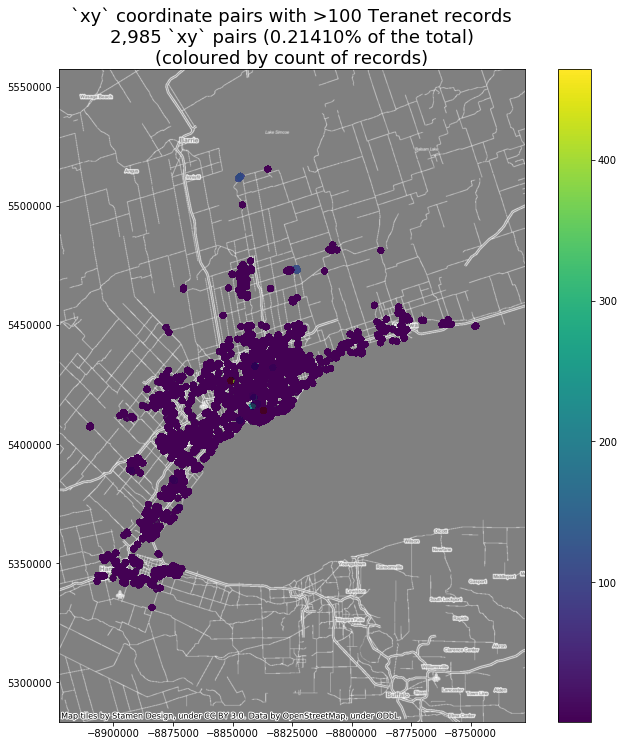

In [16]:
min_records = 100 # min Teranet records, to filter xy pairs
# get counts of Teranet records per `xy`
xy_counts = df.groupby('xy')['xy_total_sales'].max()
# select subset of `xy` that have >min_records records
focus_ids = xy_counts[xy_counts > min_records].index
# plot results
f, ax = plt.subplots(1, figsize=(12, 12))
gdf.loc[focus_ids].to_crs(epsg=3857)\
    .plot(column='pin_total_sales', legend=True, ax=ax, alpha=0.01)
# noinspection PyTypeChecker
ctx.add_basemap(ax=ax, url=ctx.sources.ST_TONER_HYBRID, alpha=0.5)
plt.title("`xy` coordinate pairs with >{0} Teranet records"
          .format(min_records) + 
          "\n{0:,} `xy` pairs ({1:.5f}% of the total)"
          .format(gdf.loc[focus_ids].index.nunique(),
                  gdf.loc[focus_ids].index.nunique()
                        / len(xy_counts) * 100) +
          "\n(coloured by count of records)",
          fontsize=18)
plt.show()

gdf = gdf.reset_index()

### Plot distributions of days since last sale

In [91]:
df['pin_days_since_last_sale'].hist(bins=200)
plt.title("Days since last sale, by `pin`")
plt.xlabel('')

KeyError: 'pin_days_since_last_sale'

In [ ]:
mask = df['days_since_last_sale_xy'] < 50
df.loc[mask, 'days_since_last_sale_xy'].hist(bins=50)

## Years since last sale per `pin` or `xy`

In [ ]:
se = df['pin_years_since_last_sale']
se[se < 40].hist(bins=100)

In [ ]:
se = df['xy_years_since_last_sale']
se[se < 40].hist(bins=100)

## Rolling sum vs rolling count or vs time

In [ ]:
# plot results
focus_id = df['id'].unique()[0]
plot_subset = df[df['id'] == focus_id]
plot_subset.plot(x='99_rolling_count', y='99_rolling_sum')

plt.suptitle("Rolling sum of purchases in department 99")
plt.title("for customer id: {0}".format(focus_id))
plt.ylabel("Rolling sum of purchases, $")
plt.xlabel("Rolling count of purchases by this customer in dept 99")
plt.grid(linestyle=':')
plt.show()

In [ ]:
# plot results
focus_id = df['id'].unique()[0]
plot_subset = df[df['id'] == focus_id]
plot_subset.plot(x='date', y='99_rolling_sum')

plt.suptitle("Rolling sum of purchases in department 99")
plt.title("for customer id: {0}".format(focus_id))
plt.ylabel("Rolling sum of purchases, $")
plt.grid(linestyle=':')
plt.show()